In [1]:
import os
import sys
from pathlib import Path
# Add project root to sys.path
project_root = Path().resolve().parent  # one level up from notebooks/
sys.path.append(str(project_root))

import pandas as pd
import numpy as np




## Customer Data Simualtion

- Using module that will simulate the demographic and property features for the models and analysis
- Simulated customer data for 100K customers of TriLink in Southern Ontario is generated
- Module creates the data with distributions we have assigned for each features, incorporating the organic inter dependency of features (if it exists)


#### **📊 Complete Column List & Simulation Logic**

##### **🆔 Identifiers (3 columns):**
1. **`customer_id`**: Format C00000001 to C00100000 (sequential)
2. **`city`**: Toronto(45%), Mississauga(18%), Hamilton(12%), London(10%), Waterloo(8%), Guelph(7%)
3. **`postal_code`**: Realistic Canadian format (M1A 1A1) based on city-specific prefixes

##### **👤 Demographics & Household (8 columns):**

4. **`age`**: 16-100, normal distribution centered at 42
   - **Logic**: Realistic working-age population distribution

5. **`household_income`**: $50K-$1M+
   - **Logic**: Base = age career stage × education multiplier × life stage multiplier × location multiplier
   - Age stages: 16-25($45K), 25-35($65K), 35-50($85K), 50-65($90K), 65+($55K)
   - Education: HS(0.8×), College(1.0×), Graduate(1.4×), Professional(1.8×)
   - Life stage: Single(0.8×), Young_Family(1.1×), Established_Family(1.3×), Empty_Nest(1.2×), Senior(0.9×)

6. **`income_bracket`**: Low/Middle/Upper_Middle/High
   - **Logic**: <$60K=Low, $60K-$90K=Middle, $90K-$150K=Upper_Middle, $150K+=High

7. **`family_size`**: 1-6 people
   - **Logic**: MUST match life stage
   - Single: 1-2 (70% solo, 30% partner)
   - Young_Family: 2-4 (small families)
   - Established_Family: 3-6 (larger families)  
   - Empty_Nest: 1-3 (mostly couples)
   - Senior: 1-2 (singles/couples)

8. **`home_ownership`**: Own/Rent/Other
   - **Logic**: Probability = 0.3 base + age factor + income factor + life stage factor
   - Age: <30(+0.2), 30-50(+0.6), 50+(+0.8)
   - Income: household_income/200000 (up to +0.4)
   - Life stage boost: Established_Family gets highest

9. **`work_from_home_flag`**: Boolean
   - **Logic**: Base 10% + education boost + income boost + age adjustment + city boost
   - Graduate/Professional: +15%
   - Upper_Middle/High income: +10%
   - Waterloo (tech hub): +20% base
   - Age <35: +5%, Age >55: -5%

10. **`education_level`**: HS/College/Graduate/Professional
    - **Logic**: Age and city dependent
    - Waterloo: Higher education (tech hub)
    - Younger (<30): More recent college graduates
    - Peak career (30-50): More advanced degrees

11. **`life_stage`**: Single/Young_Family/Established_Family/Empty_Nest/Senior
    - **Logic**: STRICT age-based logic
    - 16-25: Single(80%), Young_Family(20%)
    - 25-35: Single(40%), Young_Family(60%)
    - 35-50: Young_Family(30%), Established_Family(70%)
    - 50-65: Established_Family(60%), Empty_Nest(40%)
    - 65+: Empty_Nest(30%), Senior(70%)

##### **🏠 Property & Location (6 columns):**

12. **`home_type`**: Single_Family/Townhouse/Condo/Apartment
    - **Logic**: Income bracket + family size driven
    - High income + large family: 70% Single_Family
    - Low income: 40% Apartment
    - Family size ≥4: +20% Single_Family, -20% Apartment
    - Family size =1: -20% Single_Family, +10% Condo/Apartment

13. **`home_square_footage`**: 500-5000 sqft
    - **Logic**: Base by home type × family size factor × income factor
    - Base: Single_Family(2000), Townhouse(1300), Condo(900), Apartment(700)
    - Family size factor: 1 + (family_size-2) × 0.15
    - Income factor: household_income/80000

14. **`property_value`**: $50K-$2M+
    - **Logic**: City multiplier × crime factor × home type × size factor
    - Crime factor: max(0.5, 1.3 - crime_rate/12) [inverse relationship]
    - Home type: Single_Family(1.3×), Townhouse(1.0×), Condo(0.8×), Apartment(0.6×)
    - Size factor: square_footage/1500

15. **`neighborhood_crime_rate`**: Per 1000 residents (1.0-8.5)
    - **Logic**: Postal code specific with variation
    - Toronto M5 (downtown): 7.2, M2 (suburban): 4.2
    - Higher crime postal codes: M7(8.5), L8 Hamilton(8.2)
    - Lower crime: N1 Guelph(3.8), N2 Waterloo(4.2)

16. **`neighborhood_income_median`**: $30K-$1M+
    - **Logic**: Inverse correlation with crime rate
    - Base = city median × crime factor
    - Crime factor: max(0.6, 1.4 - crime_rate/10)
    - Lower crime = higher median income

17. **`fiber_availability`**: Boolean
    - **Logic**: City base probability + neighborhood income boost
    - City base: Toronto(85%), Waterloo(90%), Hamilton(65%)
    - Income boost: (neighborhood_median - 60000)/100000 × 0.15
    - Higher income areas get fiber first



In [2]:
from src.create_customer_data import generate_customer_profiles
customers_df = generate_customer_profiles(100000)
# Save to local
filename = f"..//data//trilink_customers_data.csv"
customers_df.to_csv(filename, index=False)

Generating 100,000 customer profiles...
Generated 0 customers...
Generated 10,000 customers...
Generated 20,000 customers...
Generated 30,000 customers...
Generated 40,000 customers...
Generated 50,000 customers...
Generated 60,000 customers...
Generated 70,000 customers...
Generated 80,000 customers...
Generated 90,000 customers...
Converting to DataFrame...

📊 Generated 100,000 customer profiles
🏙️  Cities: {np.str_('Toronto'): 44840, np.str_('Mississauga'): 18015, np.str_('Hamilton'): 12153, np.str_('London'): 10021, np.str_('Waterloo'): 8028, np.str_('Guelph'): 6943}
💰 Income brackets: {'Upper_Middle': 30872, 'Low': 30082, 'Middle': 22434, 'High': 16612}
🏠 Home types: {np.str_('Single_Family'): 38789, np.str_('Townhouse'): 24355, np.str_('Condo'): 21212, np.str_('Apartment'): 15644}
👨‍👩‍👧‍👦 Life stages: {np.str_('Established_Family'): 40689, np.str_('Young_Family'): 25807, np.str_('Single'): 17937, np.str_('Empty_Nest'): 11341, np.str_('Senior'): 4226}
📚 Education: {np.str_('Colleg

### Creating the 3 different services data - Mobile, Internet, Home Security

- For each service we will have few customers by distribution decided on each products with some actrive and some churned
- We will use this info to train each models for upsell, churn, cross sell etc

In [3]:
from src.create_service_data import generate_all_fixed_service_tables
internet_df, mobile_df, security_df = generate_all_fixed_service_tables(customers_df)

=== Generating Fixed Service Tables ===
Generating internet services with fixed contract logic...
Generated 72,756 internet services
Active services: 59,009
Churned services: 13,747
Early terminations: 3483
Contract distribution: {np.str_('Month_to_Month'): 31940, np.str_('24_Month'): 21704, np.str_('12_Month'): 19112}
Validation: Active customers with past contract end dates: 33
⚠️  Warning: Some active customers have past contract end dates

Generating mobile services with fixed contract logic...
Generated 74,395 mobile services
Active services: 56,134
Contract distribution: {np.str_('Month_to_Month'): 33859, np.str_('12_Month'): 22225, np.str_('24_Month'): 14947, np.str_('36_Month'): 3364}

Generating security devices...
Generated 151,760 security devices
Active devices: 123,261
Unique customers with security: 43,819
Device distribution: {'Smart_Doorbell': 41223, np.str_('Outdoor_Camera'): 24987, np.str_('Security_Panel'): 22919, np.str_('Indoor_Camera'): 19962, np.str_('Motion_Sens

Save to csv with the target columns added in

In [4]:
internet_df.to_csv("..//data//internet_data.csv",index=False)
mobile_df.to_csv("..//data//mobile_data.csv",index=False)
security_df.to_csv("..//data//home_security_data.csv",index=False)

In [2]:
internet_df = pd.read_csv("..//data//internet_data.csv")
mobile_df = pd.read_csv("..//data//mobile_data.csv")
security_df = pd.read_csv("..//data//home_security_data.csv")
customers_df= pd.read_csv("..//data//trilink_customers_data.csv")

Simple EDA to show distribution of Data Simulated

In [4]:
internet_df.groupby('contract_type')['contract_type'].size()

contract_type
12_Month          19112
24_Month          21704
Month_to_Month    31940
Name: contract_type, dtype: int64

In [5]:
security_df.head(5)

,device_id,customer_id,device_type,monthly_monitoring_cost,installation_date,status,app_opens_monthly,alarm_activations,false_alarms,warranty_status
0,SEC_00000001,C00000001,Smart_Doorbell,21,2025-08-07,Active,54,0,0,Active
1,SEC_00000002,C00000001,Security_Panel,46,2025-08-07,Active,34,0,0,Active
2,SEC_00000003,C00000001,Outdoor_Camera,35,2025-08-07,Active,47,4,2,Active
3,SEC_00000004,C00000005,Smart_Doorbell,13,2024-12-04,Active,33,0,0,Active
4,SEC_00000005,C00000005,Indoor_Camera,20,2024-12-04,Inactive,30,5,3,Active


In [6]:
security_df.groupby('device_type')['device_type'].size()

device_type
Indoor_Camera     19962
Motion_Sensor     16522
Outdoor_Camera    24987
Security_Panel    22919
Smart_Doorbell    41223
Smart_Lock        13885
Window_Sensor     12262
Name: device_type, dtype: int64

In [7]:
mobile_df.head(5)

,service_id,customer_id,plan_type,line_count,monthly_cost,data_overage_frequency,start_date,end_date,contract_type,contract_end_date,family_plan_flag,device_upgrade_cycle,mobile_churn,mobile_tenure_days
0,MOB_00000001,C00000001,Unlimited_Premium,4,295,0,2024-08-20,NaN,Month_to_Month,NaN,True,18,0,382.0
1,MOB_00000002,C00000002,Limited_10GB,2,91,12,2023-07-06,NaN,Month_to_Month,NaN,True,18,0,793.0
2,MOB_00000003,C00000003,Unlimited_Standard,1,79,0,2024-01-19,NaN,Month_to_Month,NaN,False,24,0,596.0
3,MOB_00000004,C00000004,Limited_5GB,1,45,10,2023-04-30,2025-04-20,Month_to_Month,NaN,False,36,1,721.0
4,MOB_00000005,C00000005,Limited_10GB,4,184,6,2023-07-26,NaN,36_Month,2026-07-26,True,36,0,773.0


In [8]:
# Churn rate as percentage
mobile_df.groupby('plan_type')['mobile_churn'].agg(['count', 'sum', 'mean']).round(3)

,count,sum,mean
plan_type,,,
Limited_10GB,18873,5730,0.304
Limited_2GB,6244,3038,0.487
Limited_5GB,11814,4873,0.412
Unlimited_Premium,11539,1422,0.123
Unlimited_Standard,25925,3198,0.123


In [9]:
internet_df.head(5)

,service_id,customer_id,plan_tier,speed_mbps,monthly_cost,data_usage_gb,connected_devices,start_date,end_date,contract_type,contract_end_date,speed_complaints,outage_count,internet_churn,early_termination,internet_tenure_days,contract_completed_percent
0,INT_00000001,C00000001,Premium_Gig,1000,100,595,12,2023-03-31,NaN,Month_to_Month,NaN,0,0,0,0,890.0,NaN
1,INT_00000002,C00000002,Premium_Gig,1000,95,469,21,2023-06-30,NaN,12_Month,2026-06-30,0,1,0,0,799.0,72.901460
2,INT_00000003,C00000003,Basic_25,25,47,50,8,2022-12-06,2024-07-24,Month_to_Month,NaN,3,3,1,0,596.0,NaN
3,INT_00000004,C00000004,Basic_25,25,46,50,5,2025-05-08,NaN,12_Month,2026-05-08,0,2,0,0,121.0,33.150685
4,INT_00000005,C00000005,Basic_25,25,43,50,13,2023-09-05,NaN,Month_to_Month,NaN,2,0,0,0,732.0,NaN


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [11]:
def create_churn_correlation_plot(df, churn_column='mobile_churn', figsize=(12, 8)):
    """
    Create a comprehensive correlation plot for churn analysis
    
    Parameters:
    df: DataFrame with service data
    churn_column: Name of the churn column
    figsize: Figure size tuple
    """
    
    # Make a copy to avoid modifying original data
    analysis_df = df.copy()
    
    # Prepare data for correlation analysis
    analysis_df = prepare_correlation_data(analysis_df)
    
    # Select numeric columns for correlation
    numeric_columns = analysis_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove ID columns and other non-meaningful columns
    exclude_cols = [col for col in numeric_columns if 'id' in col.lower() or 'counter' in col.lower()]
    numeric_columns = [col for col in numeric_columns if col not in exclude_cols]
    
    # Ensure churn column is included
    if churn_column not in numeric_columns:
        numeric_columns.append(churn_column)
    
    # Calculate correlation matrix
    correlation_matrix = analysis_df[numeric_columns].corr()
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Create heatmap
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
    
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'})
    
    plt.title(f'Correlation Matrix - Focus on {churn_column.replace("_", " ").title()}', 
              fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Return correlation with churn column
    churn_correlations = correlation_matrix[churn_column].drop(churn_column)
    return churn_correlations.sort_values(key=abs, ascending=False)

def prepare_correlation_data(df):
    """
    Prepare data by encoding categorical variables and creating useful features
    """
    analysis_df = df.copy()
    
    # Encode categorical variables
    categorical_columns = ['plan_type', 'contract_type']
    le = LabelEncoder()
    
    for col in categorical_columns:
        if col in analysis_df.columns:
            analysis_df[f'{col}_encoded'] = le.fit_transform(analysis_df[col].astype(str))
    
    # Create binary features from categorical data
    if 'plan_type' in analysis_df.columns:
        analysis_df['is_unlimited'] = analysis_df['plan_type'].str.contains('Unlimited', na=False).astype(int)
        analysis_df['is_premium'] = analysis_df['plan_type'].str.contains('Premium', na=False).astype(int)
        analysis_df['is_limited'] = analysis_df['plan_type'].str.contains('Limited', na=False).astype(int)
    
    if 'contract_type' in analysis_df.columns:
        analysis_df['is_month_to_month'] = (analysis_df['contract_type'] == 'Month_to_Month').astype(int)
        analysis_df['is_long_contract'] = analysis_df['contract_type'].isin(['24_Month', '36_Month']).astype(int)
    
    # Create derived features
    if 'monthly_cost' in analysis_df.columns and 'line_count' in analysis_df.columns:
        analysis_df['cost_per_line'] = analysis_df['monthly_cost'] / analysis_df['line_count']
    
    if 'data_overage_frequency' in analysis_df.columns:
        analysis_df['high_overage'] = (analysis_df['data_overage_frequency'] > 2).astype(int)
        analysis_df['any_overage'] = (analysis_df['data_overage_frequency'] > 0).astype(int)
    
    # Handle boolean columns
    bool_columns = analysis_df.select_dtypes(include=['bool']).columns
    for col in bool_columns:
        analysis_df[col] = analysis_df[col].astype(int)
    
    return analysis_df

def create_churn_bar_plot(df, churn_column='mobile_churn', top_n=15, figsize=(12, 8)):
    """
    Create a horizontal bar plot showing correlations with churn
    """
    analysis_df = prepare_correlation_data(df)
    
    # Get numeric columns
    numeric_columns = analysis_df.select_dtypes(include=[np.number]).columns.tolist()
    exclude_cols = [col for col in numeric_columns if 'id' in col.lower()]
    numeric_columns = [col for col in numeric_columns if col not in exclude_cols]
    
    # Calculate correlations
    correlations = analysis_df[numeric_columns].corrwith(analysis_df[churn_column])
    correlations = correlations.drop(churn_column).sort_values(key=abs, ascending=False)
    
    # Take top N correlations
    top_correlations = correlations.head(top_n)
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Create color map based on positive/negative correlation
    colors = ['red' if x > 0 else 'blue' for x in top_correlations.values]
    
    # Horizontal bar plot
    bars = plt.barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)
    
    # Customize the plot
    plt.yticks(range(len(top_correlations)), top_correlations.index)
    plt.xlabel('Correlation Coefficient', fontsize=12)
    plt.title(f'Top {top_n} Correlations with {churn_column.replace("_", " ").title()}', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Add vertical line at zero
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add correlation values as text on bars
    for i, v in enumerate(top_correlations.values):
        plt.text(v + (0.01 if v > 0 else -0.01), i, f'{v:.3f}', 
                va='center', ha='left' if v > 0 else 'right', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print correlations
    print(f"\nTop {top_n} Correlations with {churn_column}:")
    print("-" * 50)
    for i, (feature, corr) in enumerate(top_correlations.items(), 1):
        direction = "↑ Increases churn" if corr > 0 else "↓ Decreases churn"
        print(f"{i:2d}. {feature:<25} {corr:6.3f} {direction}")
    
    return top_correlations

def prepare_correlation_data(df):
    """
    Prepare data by encoding categorical variables and creating useful features
    """
    analysis_df = df.copy()
    
    # Encode categorical variables
    categorical_columns = ['plan_type', 'contract_type', 'plan_tier']
    le = LabelEncoder()
    
    for col in categorical_columns:
        if col in analysis_df.columns:
            analysis_df[f'{col}_encoded'] = le.fit_transform(analysis_df[col].astype(str))
    
    # Create binary features from categorical data
    if 'plan_type' in analysis_df.columns:
        analysis_df['is_unlimited'] = analysis_df['plan_type'].str.contains('Unlimited', na=False).astype(int)
        analysis_df['is_premium'] = analysis_df['plan_type'].str.contains('Premium', na=False).astype(int)
        analysis_df['is_limited'] = analysis_df['plan_type'].str.contains('Limited', na=False).astype(int)
    
    if 'plan_tier' in analysis_df.columns:
        analysis_df['is_basic_plan'] = (analysis_df['plan_tier'] == 'Basic_25').astype(int)
        analysis_df['is_premium_plan'] = (analysis_df['plan_tier'] == 'Premium_Gig').astype(int)
    
    if 'contract_type' in analysis_df.columns:
        analysis_df['is_month_to_month'] = (analysis_df['contract_type'] == 'Month_to_Month').astype(int)
        analysis_df['is_long_contract'] = analysis_df['contract_type'].isin(['24_Month', '36_Month']).astype(int)
    
    # Create derived features for mobile
    if 'monthly_cost' in analysis_df.columns and 'line_count' in analysis_df.columns:
        analysis_df['cost_per_line'] = analysis_df['monthly_cost'] / analysis_df['line_count']
    
    if 'data_overage_frequency' in analysis_df.columns:
        analysis_df['high_overage'] = (analysis_df['data_overage_frequency'] > 2).astype(int)
        analysis_df['any_overage'] = (analysis_df['data_overage_frequency'] > 0).astype(int)
    
    # Create derived features for internet
    if 'data_usage_gb' in analysis_df.columns and 'speed_mbps' in analysis_df.columns:
        analysis_df['usage_per_mbps'] = analysis_df['data_usage_gb'] / analysis_df['speed_mbps']
    
    if 'speed_complaints' in analysis_df.columns:
        analysis_df['high_complaints'] = (analysis_df['speed_complaints'] > 1).astype(int)
    
    if 'outage_count' in analysis_df.columns:
        analysis_df['frequent_outages'] = (analysis_df['outage_count'] > 1).astype(int)
    
    # Create tenure-based features
    for tenure_col in ['mobile_tenure_days', 'internet_tenure_days']:
        if tenure_col in analysis_df.columns:
            analysis_df[f'long_tenure_{tenure_col.split("_")[0]}'] = (analysis_df[tenure_col] > 365).astype(int)
    
    # Handle boolean columns
    bool_columns = analysis_df.select_dtypes(include=['bool']).columns
    for col in bool_columns:
        analysis_df[col] = analysis_df[col].astype(int)
    
    return analysis_df

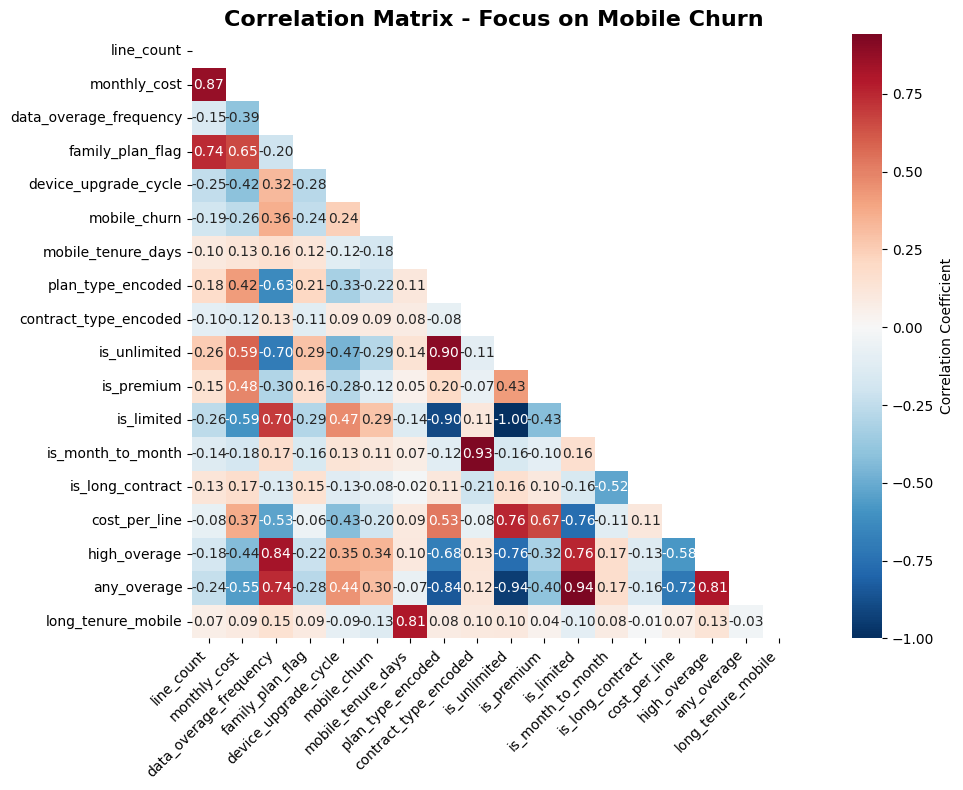

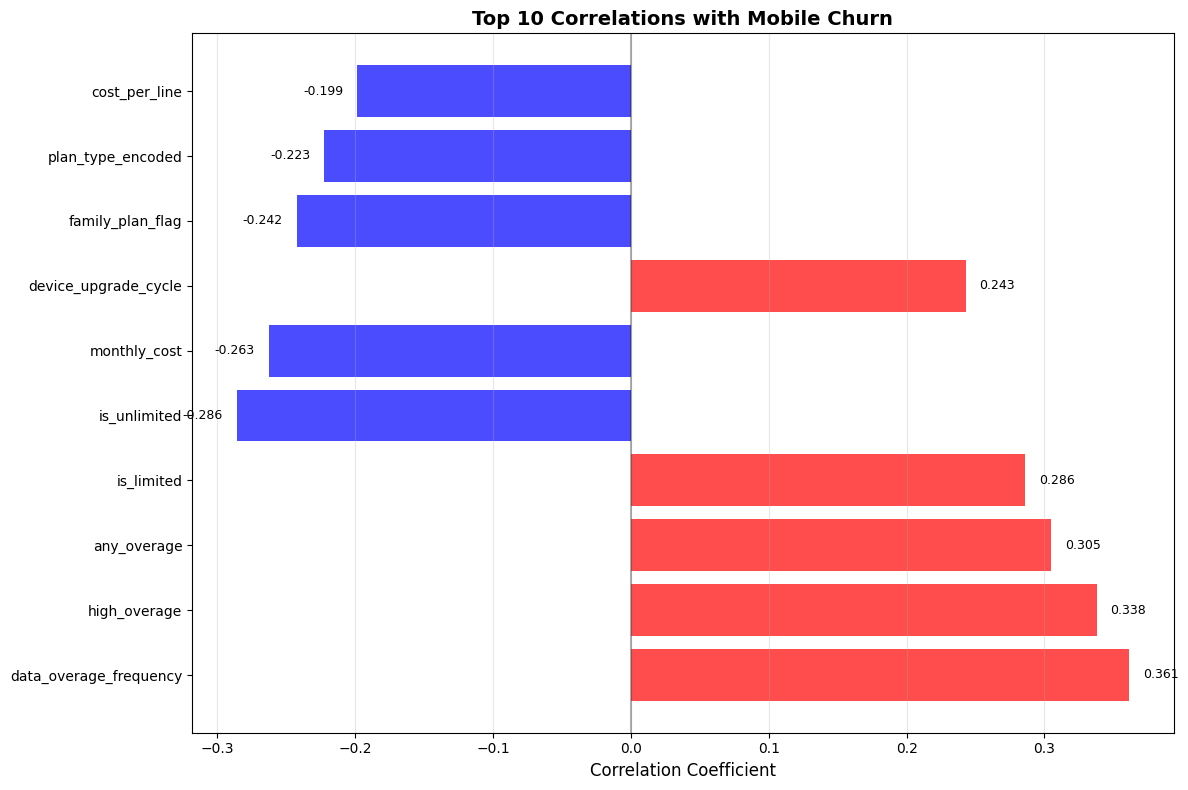


Top 10 Correlations with mobile_churn:
--------------------------------------------------
 1. data_overage_frequency     0.361 ↑ Increases churn
 2. high_overage               0.338 ↑ Increases churn
 3. any_overage                0.305 ↑ Increases churn
 4. is_limited                 0.286 ↑ Increases churn
 5. is_unlimited              -0.286 ↓ Decreases churn
 6. monthly_cost              -0.263 ↓ Decreases churn
 7. device_upgrade_cycle       0.243 ↑ Increases churn
 8. family_plan_flag          -0.242 ↓ Decreases churn
 9. plan_type_encoded         -0.223 ↓ Decreases churn
10. cost_per_line             -0.199 ↓ Decreases churn


In [12]:
correlations = create_churn_correlation_plot(mobile_df, 'mobile_churn')
bar_plot = create_churn_bar_plot(mobile_df, 'mobile_churn', top_n=10)

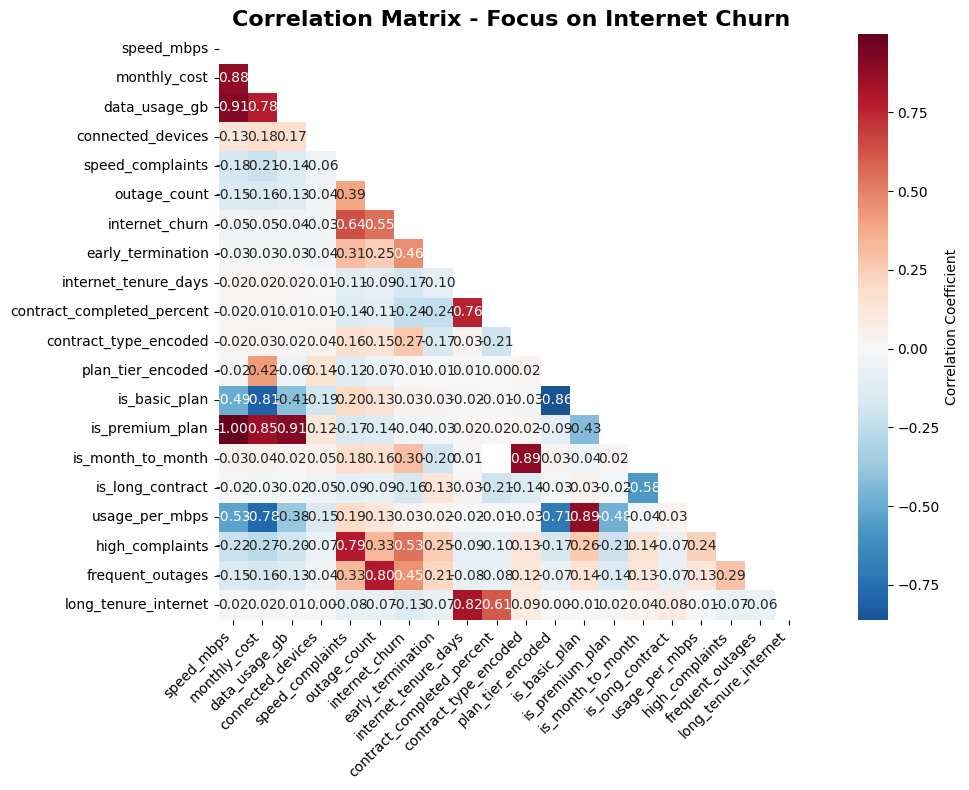

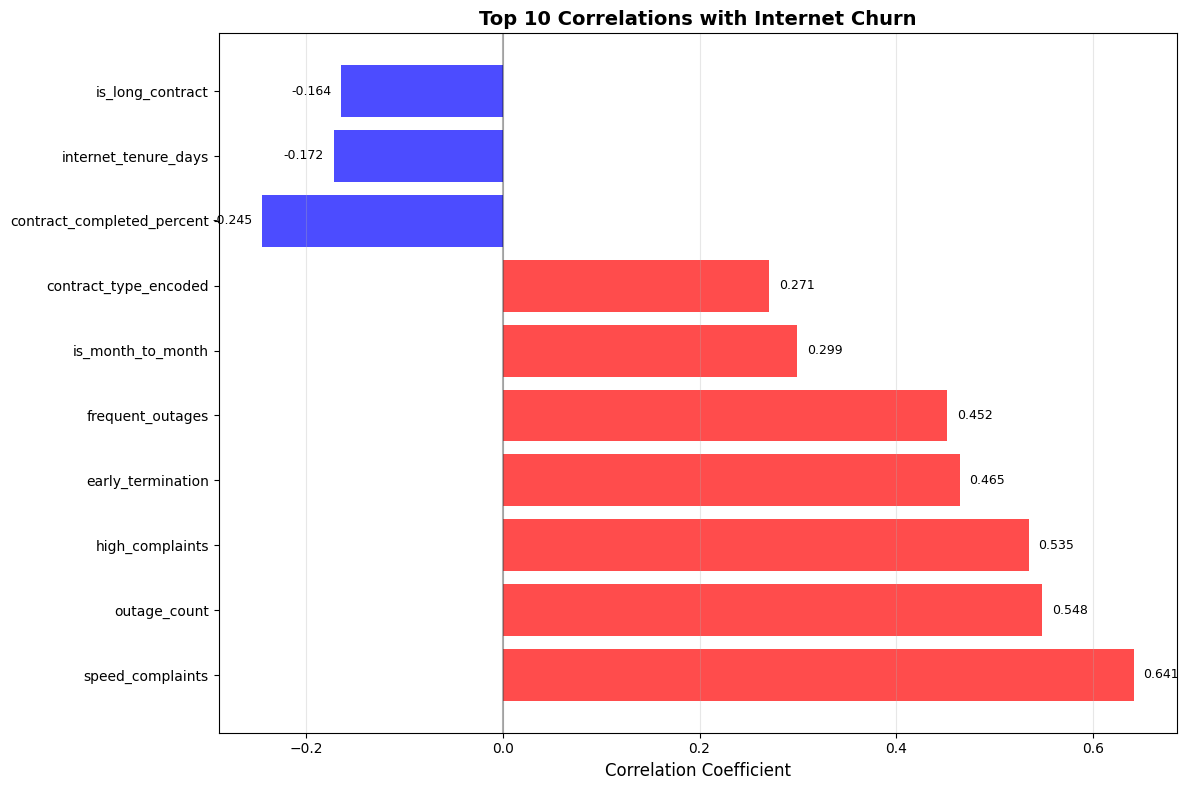


Top 10 Correlations with internet_churn:
--------------------------------------------------
 1. speed_complaints           0.641 ↑ Increases churn
 2. outage_count               0.548 ↑ Increases churn
 3. high_complaints            0.535 ↑ Increases churn
 4. early_termination          0.465 ↑ Increases churn
 5. frequent_outages           0.452 ↑ Increases churn
 6. is_month_to_month          0.299 ↑ Increases churn
 7. contract_type_encoded      0.271 ↑ Increases churn
 8. contract_completed_percent -0.245 ↓ Decreases churn
 9. internet_tenure_days      -0.172 ↓ Decreases churn
10. is_long_contract          -0.164 ↓ Decreases churn


In [13]:
correlations = create_churn_correlation_plot(internet_df, 'internet_churn')
bar_plot = create_churn_bar_plot(internet_df, 'internet_churn', top_n=10)

##### Write the tables to BigQuery

In [ ]:
##Authineticate and login to gcloud env
# !gcloud auth login
#!gcloud config set project trilink-471315
# Enable BigQuery API
#!gcloud services enable bigquery.googleapis.com

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=boyJUcn8KyAYWlSzydCWSaov8Nz6Lf&access_type=offline&code_challenge=vJ3Dq08O7X5zx52K3Xf-3Tz4a5QQwnSL6kfYlxjYNP0&code_challenge_method=S256


You are now logged in as [hazardscarn10@gmail.com].
Your current project is [trilink-472019].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [9]:

!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=2azY4oDoZ5R9TGePIMMDWrkSYnaRcz&access_type=offline&code_challenge=XPM5H9f0Reo16Kuj-xl-6OiVoPK5R_75QE8l0zuLOMk&code_challenge_method=S256


Credentials saved to file: [C:\Users\hazar\AppData\Roaming\gcloud\application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "trilink-472019" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


In [19]:
from google.cloud import bigquery
import pandas as pd
client = bigquery.Client(project="trilink-472019")

# 1. Create the dataset first
dataset_id = "trilink-472019.database"
dataset = bigquery.Dataset(dataset_id)
dataset.location = "US"  # Choose your preferred location

try:
    dataset = client.create_dataset(dataset, timeout=30)
    print(f"✅ Created dataset {dataset_id}")
except Exception as e:
    print(f"Dataset might already exist: {e}")

####2. Save the customerdata
job1 = client.load_table_from_dataframe(customers_df, "trilink-472019.database.customer_df")
job1.result()
print(f"✅ Uploaded {len(customers_df)} rows to BigQuery!")


✅ Created dataset trilink-472019.database
✅ Uploaded 100000 rows to BigQuery!


In [20]:
####3. Save the internet customer plan info
job2 = client.load_table_from_dataframe(internet_df, "trilink-472019.database.internet_df")
job2.result()
print(f"✅ Uploaded {len(internet_df)} rows to BigQuery!")


####4. Save the mobile customer plan info
job3 = client.load_table_from_dataframe(mobile_df, "trilink-472019.database.mobile_df")
job3.result()
print(f"✅ Uploaded {len(mobile_df)} rows to BigQuery!")

####5. Save the security customer plan info
job4 = client.load_table_from_dataframe(security_df, "trilink-472019.database.security_df")
job4.result()
print(f"✅ Uploaded {len(security_df)} rows to BigQuery!")

✅ Uploaded 72756 rows to BigQuery!
✅ Uploaded 74395 rows to BigQuery!
✅ Uploaded 151760 rows to BigQuery!


##### Test the connectivity to access the tables in Local Notebook from BigQuery

In [13]:
import google.cloud.bigquery
# Load the extension
%load_ext google.cloud.bigquery

d:\Work\Github\TriLink\venv\Lib\site-packages\google\cloud\bigquery\__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(


In [14]:
%%bigquery

SELECT * 
FROM `trilink-472019.database.customer_df` 
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,customer_id,city,postal_code,age,household_income,income_bracket,family_size,home_ownership,work_from_home_flag,education_level,life_stage,home_type,home_square_footage,property_value,neighborhood_crime_rate,neighborhood_income_median,fiber_availability,created_timestamp
0,C00000025,Guelph,N7C 0D2,70,110338,Upper_Middle,1,Own,False,College,Senior,Apartment,500,132707,1.1,108292,True,2025-09-06 12:52:18.379943
1,C00000032,Mississauga,L8V 3E5,22,50000,Low,1,Own,True,College,Single,Apartment,500,50000,4.5,61038,False,2025-09-06 12:52:18.379943
2,C00000039,Toronto,M8Z 3Y4,23,50000,Low,1,Own,False,Graduate,Single,Apartment,500,87563,10.2,48041,True,2025-09-06 12:52:18.381961
3,C00000087,Toronto,M0F 5N3,30,50000,Low,1,Own,False,College,Single,Apartment,500,282664,4.5,82432,True,2025-09-06 12:52:18.388771
4,C00000113,London,N3E 0D6,20,50000,Low,1,Own,False,College,Single,Apartment,500,50000,7.0,30000,False,2025-09-06 12:52:18.393114
5,C00000117,Toronto,M5P 9Z8,16,50756,Low,1,Own,True,Graduate,Single,Apartment,500,50000,7.9,68317,True,2025-09-06 12:52:18.393114
6,C00000130,Mississauga,L6R 0M5,16,50000,Low,1,Own,False,College,Single,Condo,500,183716,6.4,50981,True,2025-09-06 12:52:18.394882
7,C00000167,Guelph,N7I 9S9,55,73369,Middle,1,Own,False,College,Empty_Nest,Condo,500,50000,4.6,59849,False,2025-09-06 12:52:18.402698
8,C00000169,Toronto,M5F 4A8,16,50000,Low,1,Own,True,College,Single,Condo,500,271871,7.1,68768,False,2025-09-06 12:52:18.403682
9,C00000188,Mississauga,L4E 1B2,32,66502,Middle,1,Own,False,College,Single,Condo,500,50000,7.2,43712,False,2025-09-06 12:52:18.406275


In [21]:
%%bigquery

SELECT * 
FROM `trilink-472019.database.internet_df` 
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,service_id,customer_id,plan_tier,speed_mbps,monthly_cost,data_usage_gb,connected_devices,start_date,end_date,contract_type,contract_end_date,speed_complaints,outage_count,internet_churn,early_termination,internet_tenure_days,contract_completed_percent
0,INT_00000003,C00000003,Basic_25,25,47,50,8,2022-12-06,2024-07-24,Month_to_Month,None,3,3,1,0,596.0,NaN
1,INT_00000005,C00000005,Basic_25,25,43,50,13,2023-09-05,None,Month_to_Month,None,2,0,0,0,732.0,NaN
2,INT_00000013,C00000015,Basic_25,25,46,59,8,2023-12-08,2025-02-12,Month_to_Month,None,4,5,1,0,432.0,NaN
3,INT_00000015,C00000020,Basic_25,25,39,50,10,2023-11-19,None,Month_to_Month,None,3,1,0,0,657.0,NaN
4,INT_00000020,C00000028,Basic_25,25,41,83,21,2023-07-11,None,Month_to_Month,None,4,1,0,0,788.0,NaN


In [16]:
%%bigquery

SELECT * 
FROM trilink-472019.database.mobile_df 
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,service_id,customer_id,plan_type,line_count,monthly_cost,data_overage_frequency,start_date,end_date,contract_type,contract_end_date,family_plan_flag,device_upgrade_cycle,mobile_churn,mobile_tenure_days
0,MOB_00000034,C00000039,Limited_2GB,1,30,8,2022-09-14,2023-12-20,Month_to_Month,None,False,36,1,462.0
1,MOB_00000513,C00000692,Limited_2GB,1,30,1,2025-06-24,None,Month_to_Month,None,False,48,0,74.0
2,MOB_00000537,C00000723,Limited_2GB,1,30,11,2023-04-14,None,Month_to_Month,None,False,48,0,876.0
3,MOB_00001862,C00002471,Limited_2GB,1,30,7,2023-10-20,2025-06-18,Month_to_Month,None,False,48,1,607.0
4,MOB_00001894,C00002514,Limited_2GB,1,30,12,2023-05-12,2024-09-16,Month_to_Month,None,False,24,1,493.0


In [17]:
%%bigquery

SELECT 
  column_name,
  data_type,
  is_nullable,
  column_default
FROM `trilink-472019.database.INFORMATION_SCHEMA.COLUMNS` 
WHERE table_name = 'customer_df'
ORDER BY ordinal_position;

Query is running:   0%|          |

Downloading:   0%|          |

,column_name,data_type,is_nullable,column_default
0,customer_id,STRING,YES,NULL
1,city,STRING,YES,NULL
2,postal_code,STRING,YES,NULL
3,age,INT64,YES,NULL
4,household_income,INT64,YES,NULL
5,income_bracket,STRING,YES,NULL
6,family_size,INT64,YES,NULL
7,home_ownership,STRING,YES,NULL
8,work_from_home_flag,BOOL,YES,NULL
9,education_level,STRING,YES,NULL


In [18]:
%%bigquery

SELECT 
  column_name,
  data_type,
  is_nullable,
  column_default
FROM `trilink-472019.database.INFORMATION_SCHEMA.COLUMNS` 
WHERE table_name = 'mobile_df'
ORDER BY ordinal_position;

Query is running:   0%|          |

Downloading:   0%|          |

,column_name,data_type,is_nullable,column_default
0,service_id,STRING,YES,NULL
1,customer_id,STRING,YES,NULL
2,plan_type,STRING,YES,NULL
3,line_count,INT64,YES,NULL
4,monthly_cost,INT64,YES,NULL
5,data_overage_frequency,INT64,YES,NULL
6,start_date,STRING,YES,NULL
7,end_date,STRING,YES,NULL
8,contract_type,STRING,YES,NULL
9,contract_end_date,STRING,YES,NULL
